In [1]:
# !nvidia-smi

In [2]:
"""
Resnet-18 for classifying roof materials from PlanetScope SuperDove imagery
Case study in Washington, D.C. 
"""

import os, sys, time, glob
import geopandas as gpd
import pandas as pd
import rioxarray as rxr
import xarray as xr
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
from torchvision import transforms, utils
from torchsat.models.classification import resnet18

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold

from fiona.crs import from_epsg
from shapely.geometry import box
from os.path import join

import warnings
warnings.filterwarnings("ignore")

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

# Projection information
wgs = from_epsg(4326)
proj = from_epsg(32618)
print(f'Projected CRS: {proj}')

# maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping'

print("Successfully imported all packages!")

Projected CRS: EPSG:32618
Successfully imported all packages!


In [3]:
homedir = '/home/jovyan'

In [4]:
# Load the training data (footprints)
# gdf_path = os.path.join(maindir,'data/spatial/mod/dc_data/training/dc_data_reference_footprints.gpkg')
gdf_path = join(homedir,'opp-data/dc_data_reference_footprints.gpkg')
ref = gpd.read_file(gdf_path)
ref.head()

,uid,class_code,description,areaUTMsqft,lotSizeSqft,geometry
0,1CS,CS,Composition Shingle,357.783709,5574.0,"POLYGON ((324215.868 4313568.665, 324215.792 4..."
1,3CS,CS,Composition Shingle,918.640862,1111.0,"POLYGON ((324602.816 4311717.247, 324604.322 4..."
2,9CS,CS,Composition Shingle,1383.414170,4222.0,"POLYGON ((327253.581 4300371.859, 327258.154 4..."
3,19CS,CS,Composition Shingle,836.410297,3450.0,"POLYGON ((333608.13 4306267.691, 333607.957 43..."
4,27CS,CS,Composition Shingle,330.514264,4352.0,"POLYGON ((326482.699 4300939.466, 326487.386 4..."


In [5]:
# Observe the class imbalance
ref.class_code.value_counts()

class_code
CS    37133
ME    36864
SL    15267
UR     1279
WS     1152
TL      924
SH      783
Name: count, dtype: int64

In [6]:
# Create a numeric code column
ref['code'], _ = pd.factorize(ref['class_code'])
# Create a dictionary mapping class_code to code
code_mapping = dict(zip(ref['class_code'], ref['code']))
desc_mapping = dict(zip(ref['class_code'], ref['description']))
print(f'Code map: \n{code_mapping}\nDescription map: \n{desc_mapping}')

Code map: 
{'CS': 0, 'ME': 1, 'SL': 2, 'UR': 3, 'TL': 4, 'WS': 5, 'SH': 6}
Description map: 
{'CS': 'Composition Shingle', 'ME': 'Metal', 'SL': 'Slate', 'UR': 'Urethane', 'TL': 'Tile', 'WS': 'Wood shake/shingle', 'SH': 'Shingle'}


In [7]:
# # Calculate the longest side length of the building
# area_stats = ref.groupby('class_code').apply(footprint_area_stats).reset_index()
# area_stats

In [8]:
# # Box plot for mean footprint area across classes
# plt.figure(figsize=(5, 3))
# sns.boxplot(x='class_code', y='areaUTMsqft', data=ref)
# # Set the y-axis to log scale
# plt.yscale('log')
# plt.title('Average Footprint Area Across Classes (Log Scale)')
# plt.ylabel('Mean Area (sqm)')
# plt.xlabel('Building Class')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [9]:
# # Calculate the longest side length for polygons
# ref['longest_side_len'] = ref.geometry.apply(lambda geom: calc_longest_side(geom)[2])

# # Box plot for mean footprint area across classes
# plt.figure(figsize=(5, 3))
# sns.boxplot(x='class_code', y='longest_side_len', data=ref)
# # Set the y-axis to log scale
# plt.yscale('log')
# plt.title('Longest Side Length Across Classes')
# plt.ylabel('Length (m)')
# plt.xlabel('Building Class')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [10]:
# Identify 'pure-ish' training locations

In [11]:
# print(ref.crs)

In [12]:
# # Create centroids
# ref_pt = ref.copy()
# ref_pt = ref_pt.to_crs(epsg=32618)
# ref_pt['geometry'] = ref_pt['geometry'].centroid

# # Define the window size and half window (for boxes)
# window_size = 52 # 4 * average side length (relative neighbors (?))
# half_window = window_size / 2

# training_windows = [] # image windows with >50% of specific roof type
# training_roof_types = [] # roof type codes for valid windows

# # Loop through each footprint individually
# for geom, roof_type in zip(ref.geometry, ref['class_code']):
#     # calculate the image window as footprint buffer
#     centroid = geom.centroid
#     window = box(centroid.x - half_window, centroid.y - half_window,
#                  centroid.x + half_window, centroid.y + half_window)

#     # Intersect with centroids to get class count within window
#     intersect = ref_pt[ref_pt.intersects(window)]
    
#     # Get the total count and count for the class
#     total_count = len(intersect)
#     class_count = len(intersect[intersect['class_code'] == roof_type])

#     # Check if there is at least 50% of the roof type in that window
#     if total_count > 0 and (class_count / total_count) > 0.50:
#         training_windows.append(geom)
#         training_roof_types.append(roof_type)

#     del intersect, window, centroid

# # Create a GeoDataFrame for the training windows with roof types
# ref_windows = gpd.GeoDataFrame({
#     'geometry': training_windows, 
#     'class_code': training_roof_types
# }, crs=ref.crs)

# # Create a numeric code for the training data frame
# ref_windows['code'], _ = pd.factorize(ref_windows['class_code'])
# print("Spatial filtering complete.")

In [13]:
# # Save out
# os.getcwd()
# out_file = os.path.join(maindir,'data/spatial/mod/dc_data/rooftop_materials_training_windows.gpkg')
# ref_windows.to_file(out_file)

# del training_windows, training_roof_types, ref_pt
# gc.collect()

In [14]:
# # Plot the training locations with colors based on roof type
# fig, ax = plt.subplots(figsize=(6, 6))
# ref_windows.plot(column='class_code', ax=ax, legend=True, cmap='Set1', edgecolor='none')
# plt.title('Training Locations by Roof Material Type')
# plt.show()

In [15]:
# ref_windows.class_code.value_counts()

In [16]:
# # Perform balanced sampling (random undersampling)
# ref_bal = balance_sampling(ref_windows, ratio=20, strategy='undersample')
# ref_bal.class_code.value_counts()

In [17]:
# Perform balanced sampling (random undersampling)
ref_bal = balance_sampling(ref, ratio=10, strategy='undersample')
ref_bal.class_code.value_counts()

class_code
CS    7830
ME    7830
SL    7830
UR    1279
WS    1152
TL     924
SH     783
Name: count, dtype: int64

In [18]:
# Split the train/test data
train_df, val_df, test_df = split_training_data(ref_bal, ts=0.4, vs=0.2)

# Print the class distribution in training and validation sets to verify stratification
print("Train class distribution:\n", train_df['code'].value_counts())
print("Validation class distribution:\n", val_df['code'].value_counts())
print("Test class distribution:\n", test_df['code'].value_counts())

Train class distribution:
 code
0    4698
1    4698
2    4698
3     767
5     691
4     554
6     469
Name: count, dtype: int64
Validation class distribution:
 code
0    2505
1    2505
2    2505
3     409
5     368
4     296
6     251
Name: count, dtype: int64
Test class distribution:
 code
0    627
1    627
2    627
3    103
5     93
4     74
6     63
Name: count, dtype: int64


In [19]:
# Load our image data to check on the format
# stack_da_fp = os.path.join(maindir,'data/spatial/mod/dc_data/planet-data/dc_0623_psscene8b_final_norm.tif')
stack_da_fp = os.path.join(homedir,'opp-data/dc_0623_psscene8b_final_norm.tif')
stack_da = rxr.open_rasterio(stack_da_fp, mask=True, cache=False).squeeze()
n_bands = stack_da.values.shape[:1][0] # get a list of band names
print(
    f"shape: {stack_da.rio.shape}\n"
    f"bands: {n_bands}\n"
    f"resolution: {stack_da.rio.resolution()}\n"
    f"bounds: {stack_da.rio.bounds()}\n"
    f"sum: {stack_da.sum().item()}\n"
    f"CRS: {stack_da.rio.crs}\n"
    f"NoData: {stack_da.rio.nodata}\n"
    f"Array: {stack_da}"
)
del stack_da

shape: (8223, 6714)
bands: 6
resolution: (3.0, -3.0)
bounds: (315267.0, 4294629.0, 335409.0, 4319298.0)
sum: 8.181640625
CRS: EPSG:32618
NoData: None
Array: <xarray.DataArray (band: 6, y: 8223, x: 6714)> Size: 1GB
[331255332 values with dtype=float32]
Coordinates:
  * band         (band) int64 48B 1 2 3 4 5 6
  * x            (x) float64 54kB 3.153e+05 3.153e+05 ... 3.354e+05 3.354e+05
  * y            (y) float64 66kB 4.319e+06 4.319e+06 ... 4.295e+06 4.295e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('nir', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1', 'NISI5x5')


In [20]:
# Best params from tuning
params = {'window_size': 78, 'batch_size': 128, 'learning_rate': 0.001, 'weight_decay': 1e-4, 'momentum': 0.9, 'patience': 5}
print(f'Model params: {params}')

Model params: {'window_size': 78, 'batch_size': 128, 'learning_rate': 0.001, 'weight_decay': 0.0001, 'momentum': 0.9, 'patience': 5}


In [21]:
# Set up the Resnet-18 model

# Define whether to leverage cpu or gpu (for my local machine it is only cpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # get device for gpu or cpu
print(f'Using {device} for model dev ...')

# Grab the number of classes
n_classes = ref_bal.class_code.unique().shape[0]
print(f'There are {n_classes} roof type classes.')

# Define the Resnet-18 model (in_channels = number of bands in the image)
model = resnet18(n_classes, in_channels=n_bands, pretrained=False)

# Make model parallel and on GPU
if torch.cuda.device_count() >= 1:
    print("Using ", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
    model.to(device)
else:
    model = nn.DataParallel(model)
    print('Made cpu parallel')

# optimizer, learning rate scheduler, loss criterion, scaler (gradient)
optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'], momentum=params['momentum'], weight_decay=params['weight_decay'])
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=params['patience'], verbose=False, min_lr=1e-6)
scaler = torch.cuda.amp.GradScaler()  # initialize scaler for mixed precision

print('Ready to load data !')

Using cuda for model dev ...
There are 7 roof type classes.
Using  1 GPUs!
Ready to load data !


In [22]:
# Load the image data as a Dataset
# Uses the opimum window size calculated earlier

imdir = stack_da_fp
bs = params['batch_size']
window_size = params['window_size']

# Create the training samples
train_ds = RoofImageDatasetPlanet(train_df[['geometry', 'code']], imdir, n_bands=n_bands, img_dim=window_size)
train_loader = DataLoader(train_ds, batch_size=bs, num_workers=4, shuffle=True, pin_memory=True) 

# Create the validation samples
val_ds = RoofImageDatasetPlanet(val_df[['geometry', 'code']], imdir, n_bands=n_bands, img_dim=window_size)
val_loader = DataLoader(val_ds, batch_size=bs * 2, num_workers=2, shuffle=False, pin_memory=True)

# Create the test samples
test_ds = RoofImageDatasetPlanet(test_df[['geometry', 'code']], imdir, n_bands=n_bands, img_dim=window_size)
test_loader = DataLoader(test_ds, batch_size=bs * 2, num_workers=2, shuffle=False, pin_memory=True)

print("Training and validation data loaded!")

Training and validation data loaded!


In [23]:
# Number of samples in each class
val_counts = list(train_df['code'].value_counts())
total_samples = sum(val_counts) # total number of samples
print(f'Total samples: {total_samples};\nValue counts: {val_counts}')

# Calculate class weights
class_weights = [total_samples / count for count in val_counts]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print(f"Class weights: {class_weights}")

class_weights_norm = class_weights / class_weights.sum()
print(f"Normalized class weights: {class_weights_norm}")

# Updated loss function with weights
criterion = nn.CrossEntropyLoss(weight=class_weights_norm).to(device)

Total samples: 16575;
Value counts: [4698, 4698, 4698, 767, 691, 554, 469]
Class weights: tensor([ 3.5281,  3.5281,  3.5281, 21.6102, 23.9870, 29.9188, 35.3412],
       device='cuda:0')
Normalized class weights: tensor([0.0291, 0.0291, 0.0291, 0.1779, 0.1975, 0.2464, 0.2910],
       device='cuda:0')


In [24]:
gc.collect()

0

In [26]:
t0 = time.time()

print_freq = int(len(train_loader) // 4) # quarterly print statements

# Initialize lists to track the losses for each epoch
train_losses = [] # stores epoch train losses (average)
val_losses = [] # stores epoch validation losses (average)
batch_train_losses= [] # all batch train losses
batch_val_losses = [] # all batch val losses

num_epochs = 22 # adjust as needed
for epoch in range(1, num_epochs):
    t00 = time.time() # epoch start time

    # The current learning rate:
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch [{epoch}]. Current learning rate: {current_lr}")

    # Training loop
    model.train()

    epoch_train_losses = [] # to store the loss/batch
    
    for idx, batch in enumerate(train_loader):
        # Ensure a good batch
        batch = make_good_batch(batch)
        
        # Extract samples (image chunk, target label)
        image, target = batch['image'].to(device), batch['code'].to(device)

        optimizer.zero_grad() # reset the gradient

        # Use mixed precision
        with torch.cuda.amp.autocast():
            output = model(image.float())
            loss = criterion(output, target.long())

        scaler.scale(loss).backward()  # Mixed precision backward pass
        scaler.step(optimizer)  # Optimizer step
        scaler.update()

        # Print the train progress % and current loss
        if idx % print_freq == 0:
            print(f'\ttrain progress: [{idx * len(image)}/{len(train_loader.dataset)}] ({(100. * idx / len(train_loader)):.2f})%')
            print(f'\tbatch train loss: {loss.item():.4f};\tcumulative batch: {len(train_loader) * epoch + idx}')
        
        epoch_train_losses.append((idx, loss.item())) # append to epoch batch losses list
        batch_train_losses.append((idx, loss.item())) # track all batch losses

        del image, target, batch, output, loss
                
    # average loss for the epoch (across batches)
    train_loss = np.array(batch_train_losses)[:,1].mean()
    train_losses.append(train_loss)
    
    # validation loss
    model.eval()
    
    val_loss = 0
    correct = 0
    all_labs = []
    all_preds = []
    
    with torch.no_grad():
        for idx, batch in enumerate(val_loader):
            # Ensure a good batch
            batch = make_good_batch(batch) 
            
            # Extract samples
            image, target = batch['image'].to(device), batch['code'].to(device)
            output = model(image.float())

            # Get validation loss and predictions
            val_loss += criterion(output, target).item()
            predicted = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += predicted.eq(target.view_as(predicted)).sum().item() # Number of correct
            
            # Store the labels
            all_labs.extend(target.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

            batch_val_losses.append(val_loss) # store the batch val losses (all)

            del image, target, batch, output
            
        val_loss /= len(val_loader.dataset)/val_loader.batch_size
        val_losses.append(val_loss)
    
    print(f"\nEpoch [{epoch}] completed.")
    print(f'\ttrain loss: {train_loss}; validation loss = {val_loss:.4f}')

    acc = 100. * correct / len(val_loader.dataset)
    f1 = f1_score(all_labs, all_preds, average="weighted")
    print(f'\tAccuracy (validation): [{correct}/{len(val_loader.dataset)}] ({acc:.4f})%;\n\tF1-score (validation): {f1:.4f}')

    # Adjust the learning rate based on the validation loss
    lr_scheduler.step(val_loss)
    if optimizer.param_groups[0]['lr'] != current_lr:
        print(f"! LR-Scheduler [ReduceLROnPlateau] adjustment: {optimizer.param_groups[0]['lr']} !")
     
    t1 = (time.time() - t00) / 60
    print(f"Time to complete epoch [{epoch}]: {t1:.2f} minutes.")
    print("\n~~~~~~~~~~\n")

    # # (optional) Implement early stopping based on 'patience'
    # if val_loss < best_val_loss:
    #     best_val_loss = val_loss
    #     counter = 0  # Reset counter if we see an improvement
    # else:
    #     counter += 1  # Increment counter if no improvement after learning rate adjustment
    #     if counter >= params['patience'] + 2:
    #         print(f"Early stopping after [{epoch}] epochs.")
    #         break
    
    gc.collect() # do a garbage cleanup
    torch.cuda.empty_cache()
    
t2 = (time.time() - t0) / 60
print(f"Total elapsed time: {t2:.2f} minutes.")

Epoch [1]. Current learning rate: 0.001
	train progress: [0/16575] (0.00)%
	batch train loss: 1.5581;	cumulative batch: 130
	train progress: [4096/16575] (24.62)%
	batch train loss: 1.3719;	cumulative batch: 162
	train progress: [8192/16575] (49.23)%
	batch train loss: 1.7002;	cumulative batch: 194
	train progress: [12288/16575] (73.85)%
	batch train loss: 1.4232;	cumulative batch: 226
	train progress: [16384/16575] (98.46)%
	batch train loss: 1.4418;	cumulative batch: 258

Epoch [1] completed.
	train loss: 1.4668111957036531; validation loss = 1.4323
	Accuracy (validation): [4195/8839] (47.4601)%;
	F1-score (validation): 0.5102
Time to complete epoch [1]: 3.54 minutes.

~~~~~~~~~~

Epoch [2]. Current learning rate: 0.001
	train progress: [0/16575] (0.00)%
	batch train loss: 1.2999;	cumulative batch: 260
	train progress: [4096/16575] (24.62)%
	batch train loss: 1.4125;	cumulative batch: 292
	train progress: [8192/16575] (49.23)%
	batch train loss: 1.4854;	cumulative batch: 324
	train p

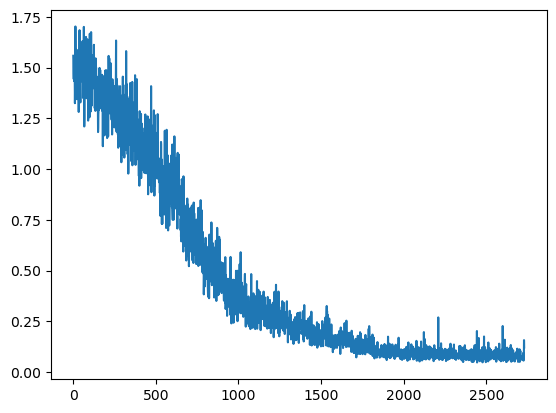

In [30]:
# Plot the model loss function
plt.plot(np.array(batch_train_losses)[:,1])

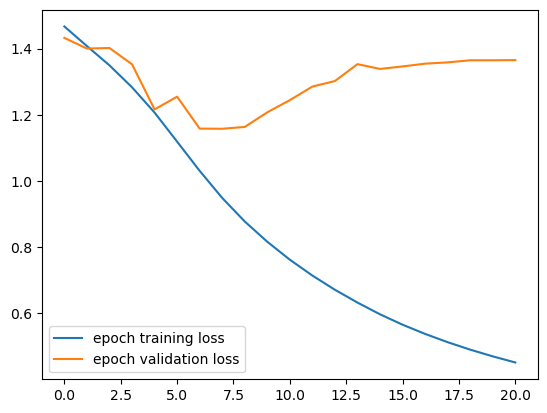

In [31]:
# Epoch training loss
plt.plot(train_losses, label='epoch training loss')
plt.plot(val_losses, label='epoch validation loss')
plt.legend()
plt.show()

In [32]:
os.getcwd()

'/home/jovyan/opp-rooftop-mapping/code'

In [35]:
# Save the model

# results directory
save_dir = os.path.join(homedir,'results/resnet18/')
roi = 'dc'

save_res = True
if save_res:

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # save the model
    step = len(train_losses)
    model_path = f"{roi}_planet_ms_ws{params['window_size']}_bs{params['batch_size']}_lr{params['learning_rate']}_ep{num_epochs}_step{step}.pt"
    model_path = os.path.join(save_dir, model_path)
    save = lambda ep: torch.save({
            'model': model.state_dict(),
            'epoch': epoch,
            'step': step,
        }, str(model_path))

    save(model_path)

In [36]:
np.savetxt(os.path.join(save_dir, 'losses_ep{}_step{}_b{}.txt'.format(num_epochs, step, bs)), np.array(batch_train_losses))
np.savetxt(os.path.join(save_dir, 'epoch_loss_ep{}_step{}_b{}.txt'.format(num_epochs, step, bs)), np.array(train_losses))
np.savetxt(os.path.join(save_dir, 'val_losses_ep{}_step{}_b{}.txt'.format(num_epochs, step, bs)), np.array(val_losses))

In [37]:
import gc

def get_prediction(m, s):
    s = s.to(device)  # Ensure the sample is moved to the correct device
    res = m(s)
    return res

true_labels = []
pred_labels = []

model.eval()  # Set model to evaluation mode

for idx, sample in enumerate(test_ds):
    try:
        if sample['code'] != 255:
            # Append true labels
            true_labels.append(sample['code'].item())  # Convert tensor to Python scalar
                        
            # Get prediction and append
            pred = get_prediction(model, sample['image'][None, ...].float().to(device))  # Ensure tensor is float and on the correct device
            pred_labels.append(pred.argmax().item())  # Convert tensor to Python scalar
            
        else:
            print(f'sample {idx} of {len(test_ds)} had class label 255, skipping...')
        
        if idx % 100 == 0:
            time.sleep(0.3)
            gc.collect()
            print(f'Processed {idx} samples...')
        
    except Exception as e:
        print(f'Error at sample {idx}: {e}, continuing...')

Processed 0 samples...
Processed 100 samples...
Processed 200 samples...
Processed 300 samples...
Processed 400 samples...
Processed 500 samples...
Processed 600 samples...
Processed 700 samples...
Processed 800 samples...
Processed 900 samples...
Processed 1000 samples...
Processed 1100 samples...
Processed 1200 samples...
Processed 1300 samples...
Processed 1400 samples...
Processed 1500 samples...
Processed 1600 samples...
Processed 1700 samples...
Processed 1800 samples...
Processed 1900 samples...
Processed 2000 samples...
Processed 2100 samples...
Processed 2200 samples...


In [38]:
# Ensure 'class_code' is of categorical dtype
test_df['code'] = test_df['code'].astype('category')

# Create the dictionary mapping
cat_dict = dict(enumerate(test_df['code'].cat.categories))
print(cat_dict)

# Filter the class codes present in the test set
class_codes_numbers = [k for k in cat_dict.keys() if cat_dict[k] in test_df['code'].unique().tolist()]

cor_labels = [cat_dict[c] for c in class_codes_numbers]
print(cor_labels)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
[0, 1, 2, 3, 4, 5, 6]


(array([708., 680.,   0., 651.,   0.,  93.,  34.,   0.,  38.,  10.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

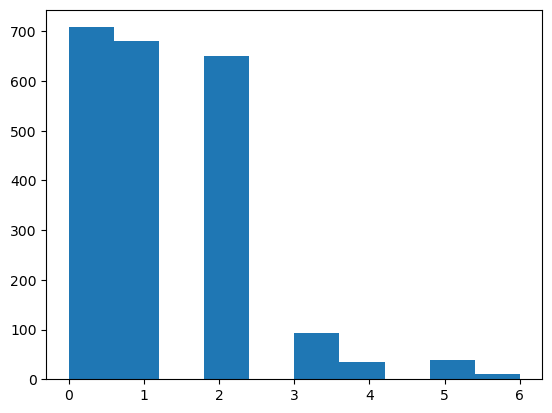

In [40]:
plt.hist(pred_labels)

In [41]:
sum(p.numel() for p in model.parameters() if p.requires_grad) # number of trainable model parameters

11189511

In [42]:
# Generate the classification report
cr_df = pd.DataFrame(classification_report(true_labels, pred_labels, target_names=cor_labels, output_dict=True)).transpose()
print(cr_df)

              precision    recall  f1-score      support
0              0.612994  0.692185  0.650187   627.000000
1              0.747059  0.810207  0.777353   627.000000
2              0.608295  0.631579  0.619718   627.000000
3              0.505376  0.456311  0.479592   103.000000
4              0.411765  0.189189  0.259259    74.000000
5              0.578947  0.236559  0.335878    93.000000
6              0.100000  0.015873  0.027397    63.000000
accuracy       0.642276  0.642276  0.642276     0.642276
macro avg      0.509205  0.433129  0.449912  2214.000000
weighted avg   0.621870  0.642276  0.625644  2214.000000


In [44]:
cr_df.to_csv(os.path.join(save_dir,'classification_report.csv'))

In [45]:
for c in cor_labels:
    print(test_df.loc[test_df['code'] == c].shape[0])

627
627
627
103
74
93
63


<Figure size 640x480 with 0 Axes>

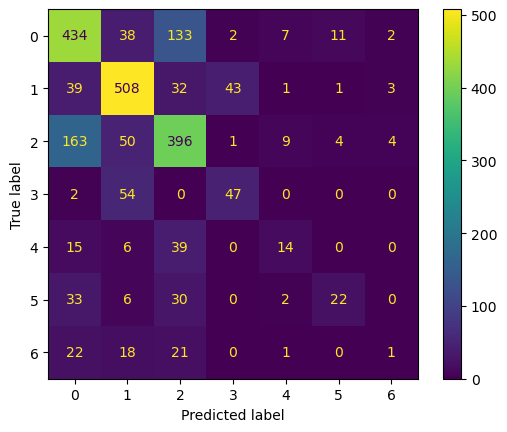

In [49]:
class_label_names = cor_labels # get these smartly somehow... categories got a bit mixed up
class_labels = class_codes_numbers
cm = confusion_matrix(true_labels, pred_labels, labels=cor_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cor_labels)
plt.savefig(os.path.join(homedir,'results/figures/confusion_matrix.png'), dpi=300, bbox_inches='tight')
disp.plot()